In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from my_xgboost import XGBoost  # 请确保你的自定义XGBoost支持分类

# 加载数据集
data = load_iris()
X, y = data.data, data.target
feature_names = data.feature_names

# 划分数据集（添加分层抽样）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # 保持类别分布
)

# 结果收集字典
results = {}

def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1_Macro': f1_score(y_true, y_pred, average='macro'),
        'Precision_Macro': precision_score(y_true, y_pred, average='macro'),
        'Recall_Macro': recall_score(y_true, y_pred, average='macro')
    }

# =====================
# 1. XGBoost
# =====================
start_time = time.time()
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['XGBoost'] = evaluate_model(y_test, xgb_model.predict(X_test))
results['XGBoost']['Time'] = train_time

# =====================
# 2. Scikit-learn
# =====================
start_time = time.time()
sk_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sk_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['Sklearn'] = evaluate_model(y_test, sk_model.predict(X_test))
results['Sklearn']['Time'] = train_time

# =====================
# 3. H2O (需要转换目标变量为因子)
# =====================
# h2o.init()
# train_h2o = h2o.H2OFrame(np.column_stack((X_train, y_train)), 
#                        column_names=list(feature_names)+['target'])
# test_h2o = h2o.H2OFrame(np.column_stack((X_test, y_test)), 
#                       column_names=list(feature_names)+['target'])

# # 将目标变量转换为因子（分类任务必须）
# train_h2o['target'] = train_h2o['target'].asfactor()
# test_h2o['target'] = test_h2o['target'].asfactor()

# start_time = time.time()
# h2o_model = H2OGradientBoostingEstimator(
#     ntrees=100,
#     learn_rate=0.1,
#     max_depth=3,
#     seed=42,
#     distribution="multinomial"
# )
# h2o_model.train(x=feature_names, y="target", training_frame=train_h2o)
# train_time = time.time() - start_time

# # 转换预测结果为numpy数组
# h2o_pred = h2o_model.predict(test_h2o)['predict'].as_data_frame().values.flatten()
# results['H2O'] = evaluate_model(y_test, h2o_pred.astype(int))
# results['H2O']['Time'] = train_time
# h2o.cluster().shutdown()

# =====================
# 4. My XGBoost（需确认支持分类）
# =====================
start_time = time.time()
my_model = XGBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective='multiclass',           # 添加类别数参数
    eps=0.5
)
my_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['My XGBoost'] = evaluate_model(y_test, my_model.predict(X_test))
results['My XGBoost']['Time'] = train_time



Training XGBoost: 100%|██████████████| 100/100 [elapsed: 00:00 remaining: 00:00]


Performance Comparison:
            Accuracy  F1_Macro  Precision_Macro  Recall_Macro      Time
XGBoost     0.933333  0.933333         0.933333      0.933333  0.073806
Sklearn     0.966667  0.966583         0.969697      0.966667  0.306760
My XGBoost  0.966667  0.966583         0.969697      0.966667  0.347557


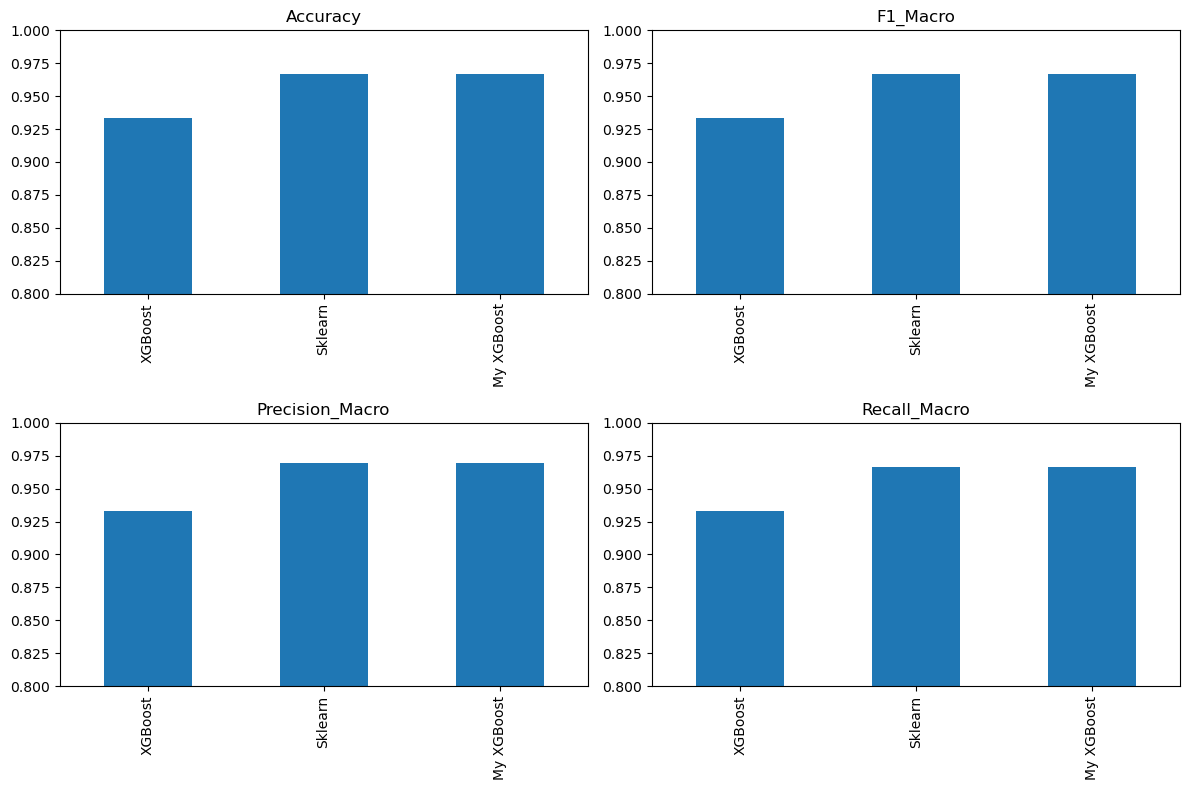

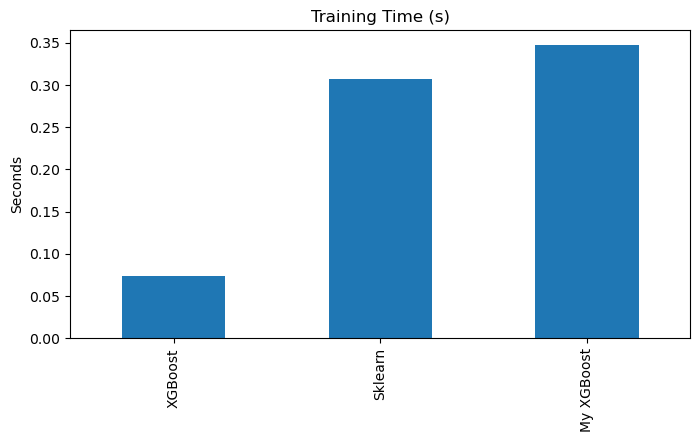

In [3]:
# =====================
# 结果可视化
# =====================
df_results = pd.DataFrame(results).T
metrics = ['Accuracy', 'F1_Macro', 'Precision_Macro', 'Recall_Macro', 'Time']

# 绘制指标对比
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics[:-1]):  # 排除Time指标
    plt.subplot(2, 2, i+1)
    df_results[metric].plot(kind='bar', title=metric)
    plt.ylim(0.8, 1.0)  # 根据实际结果调整范围
plt.tight_layout()

# 时间对比
plt.figure(figsize=(8, 4))
df_results['Time'].plot(kind='bar', title='Training Time (s)')
plt.ylabel('Seconds')

# 显示表格结果
print("==========================")
print("Performance Comparison:")
print(df_results[metrics])
print("==========================")

plt.show()